In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import plotly.graph_objects as go
import os
import plotly.express as px
from scipy.stats import skew,kurtosis

In [106]:
from pathlib import Path
import pandas as pd
data_dir = Path(r'/Users/apple/Desktop/SAPintern/archive/spiral/')
draw_df = pd.DataFrame({'path': list(data_dir.glob('*/*/*.png'))})
draw_df['img_id'] = draw_df['path'].map(lambda x: x.stem)
draw_df['disease'] = draw_df['path'].map(lambda x: x.parent.stem)
draw_df['validation'] = draw_df['path'].map(lambda x: x.parent.parent.stem)
draw_df.sample(5)

,path,img_id,disease,validation
43,/Users/apple/Desktop/SAPintern/archive/spiral/...,V08PE03,parkinson,training
55,/Users/apple/Desktop/SAPintern/archive/spiral/...,V03PE06,parkinson,training
66,/Users/apple/Desktop/SAPintern/archive/spiral/...,V04PE02,parkinson,training
77,/Users/apple/Desktop/SAPintern/archive/spiral/...,V55HE14,healthy,testing
20,/Users/apple/Desktop/SAPintern/archive/spiral/...,V02HE02,healthy,training


## features by Xinjie

In [107]:
def compare_hist(draw_df):
    for i in ["corr","chi","inter","bar","hell","chi_alt"]:
        draw_df[i] = np.nan
    for j in range(len(draw_df)):
        img=cv2.imread(str(draw_df.iloc[j,0]),cv2.IMREAD_GRAYSCALE)
        ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
        median=cv2.medianBlur(thresh,3)
        G_X = cv2.reduce(thresh, 0 ,cv2.REDUCE_SUM,dtype=cv2.CV_32F)
        G_Y = cv2.reduce(thresh, 1 ,cv2.REDUCE_SUM,dtype=cv2.CV_32F)
        hist1=cv2.calcHist([G_X],[0],None,[65536],[0,65535])
        hist2=cv2.calcHist([G_Y],[0],None,[65536],[0,65535])
        for k in range(4,10):
            draw_df.iloc[j,k]=cv2.compareHist(hist1,hist2,k-4)
    return draw_df

In [108]:
def num_point_projection(draw_df):
    for i in ["mean","median",'range','std','skew','kur']:
        draw_df[i] = np.nan
    
    for j in range(len(draw_df)):
        img=cv2.imread(str(draw_df.iloc[j,0]),cv2.IMREAD_GRAYSCALE)
        ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
        median=cv2.medianBlur(thresh,3)
        sum_bycolumn=np.sum(median, axis=1) # sum by column
        sum_byrow=np.sum(median, axis=0) # sum by row
        series=np.hstack((sum_byrow,sum_bycolumn))
        series=series.reshape((1,-1))
        
        draw_df.iloc[j,10]=np.mean(series[0])
        draw_df.iloc[j,11]=np.median(series[0])
        draw_df.iloc[j,12]=np.ptp(series[0])
        draw_df.iloc[j,13]=np.std(series[0])
        draw_df.iloc[j,14]=skew(series[0])
        draw_df.iloc[j,15]=kurtosis(series[0])
    return draw_df

In [109]:
def asym_disc(draw_df):
    for i in ['h_dis',"v_dis","asym_disc"]:
        draw_df[i] = np.nan
        
    for j in range(len(draw_df)):
        img=cv2.imread(str(draw_df.iloc[j,0]),cv2.IMREAD_GRAYSCALE)
        ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
        median=cv2.medianBlur(thresh,3)
        M = cv2.moments(median)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        left_x=np.amin(np.argwhere(median>0),axis=0)[0] # leftmost x
        right_x=np.amax(np.argwhere(median>0),axis=0)[0] # rightmost x
        up_y=np.amin(np.argwhere(median>0),axis=0)[1] # up y
        btm_y=np.amax(np.argwhere(median>0),axis=0)[1] # bottom x

        draw_df.iloc[j,16]=abs((cY-up_y)-(btm_y-cY))/(btm_y-up_y)
        draw_df.iloc[j,17]=abs((cX-left_x)-(right_x-cX))/(right_x-left_x)
        draw_df.iloc[j,18]=draw_df.iloc[j,16]+draw_df.iloc[j,17]
    return draw_df

In [110]:
def generate_features(draw_df):
    draw_df1=compare_hist(draw_df)
    draw_df2=num_point_projection(draw_df1)
    draw_df3=asym_disc(draw_df2)
    return draw_df3

In [111]:
df=generate_features(draw_df)

## feature: brightness + color difference

In [112]:
def get_bright_colordiff(address):
    img=cv2.imread(str(address),cv2.IMREAD_GRAYSCALE)
    return img.mean(),img.std()

## feature: line thickness + line uniformity

In [113]:
## input:  line in a image matrix
## output: m: skeletonized line with i-pixel width nonzero groups, width: the average width in this line area
def skeletonize_line(matrix):
    l = len(matrix)
    m=matrix.copy()
    for i in range(l):
        if i<(l-1) and m[i]>0 and m[i+1]>0: #exclude the last pixel on this vertical line
            m[i]=0
        else:
            continue
    if m.sum()!=0:
        width = matrix.sum()/(m.sum())
    else:
        width = 0
    return m,width

In [114]:
## input: binary image
## output: 1.img2: skeletonized img 2.width_list: a list of 256 size for difference width of different line area
def skeletonize_img_vertical(img):
    img2=img.copy()
    width_list = [0]*img.shape[1]
    for j in range(img.shape[1]):
        img2[:,j],width_list[j]=skeletonize_line(img2[:,j])
    width = [i for i in width_list if i != 0]
    return img2,width

In [115]:
def skeletonize_img_horizontal(img):
    img2=img.copy()
    width_list = [0]*img.shape[0]
    for i in range(img.shape[0]):
        img2[i,:],width_list[i]=skeletonize_line(img2[i,:])
    width = [i for i in width_list if i != 0]
    return img2,width

In [116]:
def get_thick_uniform(address):
    img=cv2.imread(str(address),cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)

    skeleton_v, width_v = skeletonize_img_vertical(thresh)
    skeleton_h, width_h = skeletonize_img_horizontal(thresh)
    thickness = (thresh.sum()/skeleton_v.sum()+thresh.sum()/skeleton_h.sum())/2
    uniformity = np.array(width_v+width_h).std()
    return thickness, uniformity

## feature: num of circles and resulted mean and std

In [117]:
#input: 1d array 
#output: number of cut points in this line
def count_points(matrix):
    count=0
    for i in range(len(matrix)):
        pixel = matrix[i]
        if i==0 and pixel>0: #the first pixel
            count+=1
        elif pixel>0 and matrix[i-1]==0:
            count+=1
    return count

In [118]:
#input: binary image
#output: horizontal nonzero points, vertical nonzero points
def count_line_cutpoint(img):
    horizon =[0]*img.shape[0]
    vertical =[0]*img.shape[1]
    for i in range(img.shape[0]):
        horizon[i]=count_points(img[i,:])
    for j in range(img.shape[1]):
        vertical[j]=count_points(img[:,j])
    return horizon,vertical

In [119]:
def get_num_circles_mean_std(address):
    img=cv2.imread(str(address),cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
    median=cv2.medianBlur(thresh,3)
    
    h_ma, v_ma = count_line_cutpoint(median)
    ma=np.hstack((h_ma, v_ma))
    num_circles= max(max(h_ma),max(v_ma))//2
    return num_circles,ma.mean(),ma.std()

In [124]:
def generate_other_features(df):
    draw_df=df.copy()
    draw_df['brightness'] = draw_df['path'].apply(get_bright_colordiff).apply(lambda x:x[0])
    draw_df['colordiff'] = draw_df['path'].apply(get_bright_colordiff).apply(lambda x:x[1])
    draw_df['line_thickness'] = draw_df['path'].apply(get_thick_uniform).apply(lambda x:x[0])
    draw_df['line_diff'] = draw_df['path'].apply(get_thick_uniform).apply(lambda x:x[1])
    draw_df['num_circles'] = draw_df['path'].apply(get_num_circles_mean_std).apply(lambda x:x[0])
    draw_df['cutpoints_mean'] = draw_df['path'].apply(get_num_circles_mean_std).apply(lambda x:x[1])
    draw_df['cutpoints_std'] = draw_df['path'].apply(get_num_circles_mean_std).apply(lambda x:x[2])
    return draw_df

In [144]:
df_full = generate_other_features(df)

In [128]:
df_full.to_csv('features_full.csv',index=False)

In [145]:
df_full.head()

,path,img_id,disease,validation,corr,chi,inter,bar,hell,chi_alt,...,h_dis,v_dis,asym_disc,brightness,colordiff,line_thickness,line_diff,num_circles,cutpoints_mean,cutpoints_std
0,/Users/apple/Desktop/SAPintern/archive/spiral/...,V09HE02,healthy,training,0.880671,101.704455,186.0,0.316855,136.218735,547.836345,...,0.003984,0.071429,0.075413,236.048767,20.246390,3.157084,3.124532,3,3.767578,1.738434
1,/Users/apple/Desktop/SAPintern/archive/spiral/...,V55HE06,healthy,training,0.647127,367.760670,148.0,0.435655,264.831211,1383.869354,...,0.000000,0.243028,0.243028,232.148560,20.866771,4.314568,3.184558,3,3.490234,1.934449
2,/Users/apple/Desktop/SAPintern/archive/spiral/...,V55HE07,healthy,training,0.764233,354.829672,176.0,0.375133,193.550509,849.385885,...,0.148594,0.144000,0.292594,227.639099,23.835954,4.413340,5.216124,4,4.431641,2.325809
3,/Users/apple/Desktop/SAPintern/archive/spiral/...,V09HE03,healthy,training,0.919871,89.425385,196.0,0.291388,108.284771,629.338884,...,0.004016,0.035573,0.039589,235.736557,17.516144,2.866226,2.352902,4,3.849609,1.590634
4,/Users/apple/Desktop/SAPintern/archive/spiral/...,V55HE11,healthy,training,0.688515,276.975552,146.0,0.438437,261.344521,1131.760360,...,0.004082,0.020080,0.024162,229.409667,31.169923,4.076498,5.021474,3,3.587771,1.484200


## EDA

In [146]:
df_full['target']=df_full['disease'].apply(lambda x: int(x=='parkinson'))

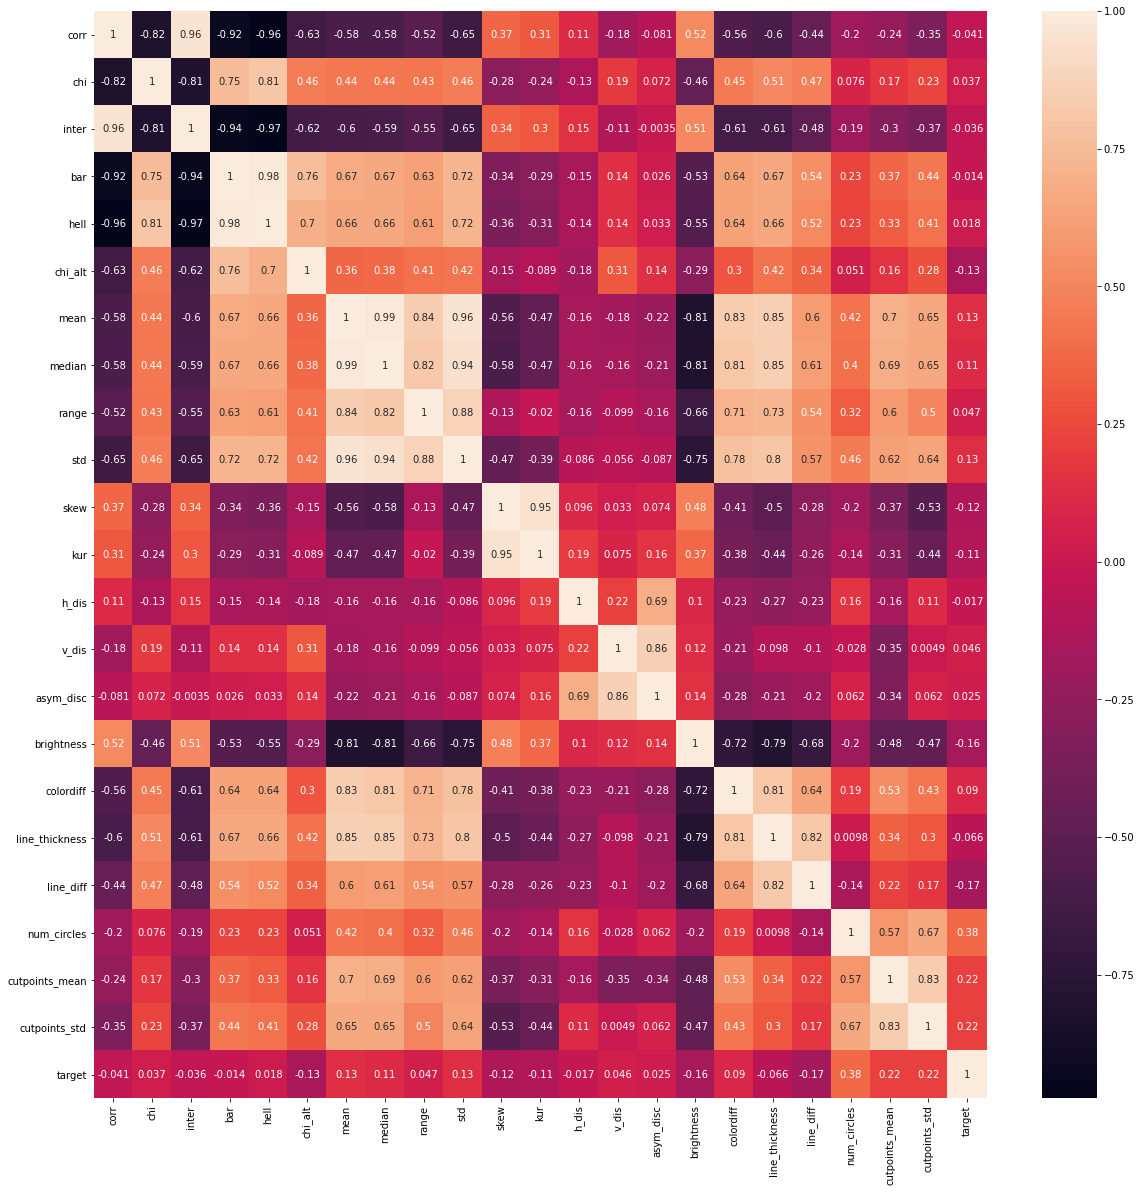

In [147]:
plt.figure(figsize=(20,20))
sns.heatmap(df_full.corr(),annot=True)
plt.show()

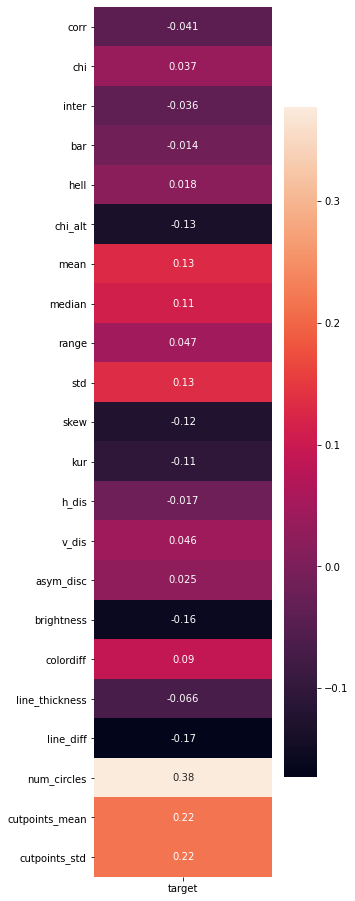

In [155]:
plt.figure(figsize=(4,16))
sns.heatmap(df_full.corr()[['target']][:-1],annot=True)
plt.show()